In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")

In [3]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [4]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily =TavilySearchResults()

C:\Users\WIIS\AppData\Local\Temp\ipykernel_20760\1016542888.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily =TavilySearchResults()


In [6]:
tools=[arxiv,wiki,tavily]

In [7]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")

In [8]:
llm.invoke("Who are you?")

AIMessage(content='<think>\nOkay, the user asked "Who are you?" and I need to respond. First, I should recall my standard introduction. I\'m Qwen, a large language model developed by Alibaba Cloud\'s Tongyi Lab. I should mention my capabilities like answering questions, creating text, and supporting programming. Also, I need to include how I can help the user. But I need to keep it concise and friendly. Let me check if there\'s anything new in my version that should be highlighted. Oh right, the user might be interested in the latest features like code writing or multi-language support. I should make sure the response is clear and approachable, inviting them to ask for help. Avoid technical jargon. Make sure it\'s all in natural, conversational English. Let me put that together smoothly.\n</think>\n\nHello! I\'m Qwen, a large language model developed by Tongyi Lab under Alibaba Group. I can help you with answering questions, creating text (like writing stories, official documents, emai

In [9]:
llm_with_tools=llm.bind_tools(tools=tools)

In [10]:
llm_with_tools.invoke("what is the recent news in ai?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news in AI. I need to figure out which tool to use here. Let me check the available functions. There\'s arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best choice for general news. Wikipedia is good for general knowledge but might not have the most up-to-date news. The third option, tavily_search_results_json, is described as a search engine optimized for current events. That sounds like the right tool here.\n\nI should use tavily_search_results_json with a query like "recent news in AI" or "latest AI developments". Let me make sure the parameters are correct. The function requires a "query" parameter, which I\'ll set to "recent news in AI". \n\nDouble-checking if there\'s any reason not to use this tool. The user didn\'t specify a particular subfield of AI, so a general query should work. I\'ll proceed with that.\n', 'tool_calls': [{'

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages 

In [12]:
class state(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [13]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [26]:
#Node Defintition
def tool_calling_llm(state:state):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build Graph
builder=StateGraph(state)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

In [27]:
# Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

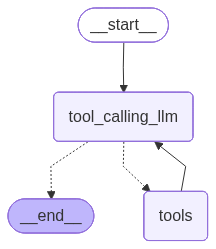

In [28]:
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
messages=graph.invoke({"messages":"give latest news in ai and then give about attention is all needed research paper"})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

give latest news in ai and then give about attention is all needed research paper
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5ncr2ebbd)
 Call ID: 5ncr2ebbd
  Args:
    query: latest news in AI 2024
  arxiv (18xqsv33h)
 Call ID: 18xqsv33h
  Args:
    query: Attention is All You Need research paper
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Year in review: Google's biggest AI advancements of 2024", "url": "https://blog.google/technology/ai/2024-ai-extraordinary-progress-advancement/", "content": "This article summarizes Google's AI advancements in 2024, highlighting their commitment to responsible development.\n Google released Gemini 2.0, a powerful AI model designed for the \"agentic era,\" and integrated it into various products.\n They made s